<h1><center><b>K-Means Clustering</b></center></h1>
<p><center>Adrián Rubén Bedón Campaña</center></p>
<p><center>Pablo Alejandro Chasipanta Silva</center></p>
<p><center>José Miguel Merlo Santacruz</center></p>
<p><center>Dennis Steven Ocaña Santamaría</center></p>
<p><center>Xavier Alejandro Ramos Vásconez</center></p>

#### Objetivo
Segmentar a los clientes en función de datos de comportamiento mediante la agrupación K-Means y analizar las características de cada segmento para obtener información útil.

#### Importación de Librerías

In [ ]:
# Libraries for data manipulation
import pandas as pd
import seaborn as sns
# Libraries for plotting
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
# Libraries for date and time manipulation
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse
# Libraries for K-means analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
# Libraries for scaling
from pca import pca
# General libraries
import numpy as np

Con la finalidad de entender la información que contiene el dataset entregado, se implementó la función `isna()` junto con la función `any()` y `sum()` con la finalidad de detectar filas que contengan valores vacíos <b>(NaN)</b> y tras la identificación de las columnas que contenían estos valores <b>(Description y CustomerID)</b> y la cantidad de filas afectadas se decidió eliminar cada una de estas filas para que no afectaran al estudio.

#### Carga y Exploración de Datos

In [2]:
data = pd.read_excel(r'C:\Adrian\Universidad\9no Semestre\3. Fri. - Inteligencia Artificial II\Online Retail.xlsx')

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
nan_rows_initial = data.isna().any()
nan_count_initial = data.isna().sum()
dtype_columns_initial = data.dtypes

data = data.dropna()

nan_rows_cleaned = data.isna().any()
nan_count_cleaned = data.isna().sum()
dtype_columns_cleaned = data.dtypes

nan_summary = pd.DataFrame({
    'Missing Values - Initial': nan_rows_initial,
    'NaN Count - Initial': nan_count_initial,
    'Dtype - Initial': dtype_columns_initial,
    'Missing Values - Cleaned': nan_rows_cleaned,
    'NaN Count - Cleaned': nan_count_cleaned,
    'Dtype - Cleaned': dtype_columns_cleaned
})

display(nan_summary)

,Missing Values - Initial,NaN Count - Initial,Dtype - Initial,Missing Values - Cleaned,NaN Count - Cleaned,Dtype - Cleaned
InvoiceNo,False,0,object,False,0,object
StockCode,False,0,object,False,0,object
Description,True,1454,object,False,0,object
Quantity,False,0,int64,False,0,int64
InvoiceDate,False,0,datetime64[ns],False,0,datetime64[ns]
UnitPrice,False,0,float64,False,0,float64
CustomerID,True,135080,float64,False,0,float64
Country,False,0,object,False,0,object


Con esta limpieza inicial realizada se identificó que el dataset trabajaba con variables numéricas que hacían referencia a valores cuantitativos <b>(Quantity)</b> y monetarios <b>(UnitPrice)</b> por lo que con la finalidad de evitar cualquier anomalía en estos valores <b>(uso de números negativos)</b> se decidió conservar solamente aquellas filas donde los valores para estos campos eran superiores a 0.

In [4]:
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']

display(data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


#### Ingeniería de Características
##### Análisis RFM (Recencia, Frecuencia y Valor Monetario)

El análisis RFM es una técnica utilizada para identificar a clientes actuales que tienen más posibilidades de responder a una oferta. Esta técnica es muy común en el marketing directo. El análisis de RFM se fundamenta en lo siguiente:

- El factor más importante para identificar a los clientes que podrían responder a una nueva oferta es la <b>recencia</b>. Esto debido a que los clientes que han realizado adquisiciones recientemente tienen más posibilidades de volver a adquirir nuevos productos frente a aquellos que han adquirido productos en el pasado.

- El segundo factor influyente es la <b>frecuencia</b>. Los clientes que han adquirido más productos tienen más posibilidades de responder que aquellos que han adquirido menos productos.

- El tercer factor es la cantidad total invertida, a la que se le denomina <b>valor monetario</b>. Aquellos clientes que han realizado una inversión mayor tienen más posibilidades de responder que aquellos que han invertido menos.

<i>Fuente: [IBM - Análisis de RFM](https://www.ibm.com/docs/es/spss-statistics/saas?topic=marketing-rfm-analysis)</i>

Una vez obtenidas cada una de estos factores se realizó un escalado de datos:

- <b>Escalado Estándar (Z-score normalization)</b>: Este método de escalado se basa en el concepto de distribución normal estándar, que es una distribución estadística en la que los valores se agrupan alrededor de una media de cero y una desviación estándar de uno.

    <i>Fuente: [LinkedIn - ¿Cómo mejora la normalización de la puntuación z el análisis de datos?](https://www.linkedin.com/advice/3/how-does-z-score-normalization-improve-your-data-ifnic?lang=es&originalSubdomain=es#:~:text=La%20normalizaci%C3%B3n%20de%20la%20puntuaci%C3%B3n%20Z%2C%20tambi%C3%A9n%20conocida%20como%20estandarizaci%C3%B3n,en%20los%20rangos%20de%20valores.)</i>

In [5]:
# Recency Date Calculation
recency_date = parse(max(pd.to_datetime(data['InvoiceDate'])).strftime('%Y-%m-%d')) + timedelta(days=1)

# RFM Analysis
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate':lambda x: (recency_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalRevenue': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalRevenue': 'Monetary'
})

# Features normalization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

#### K-Means Clustering

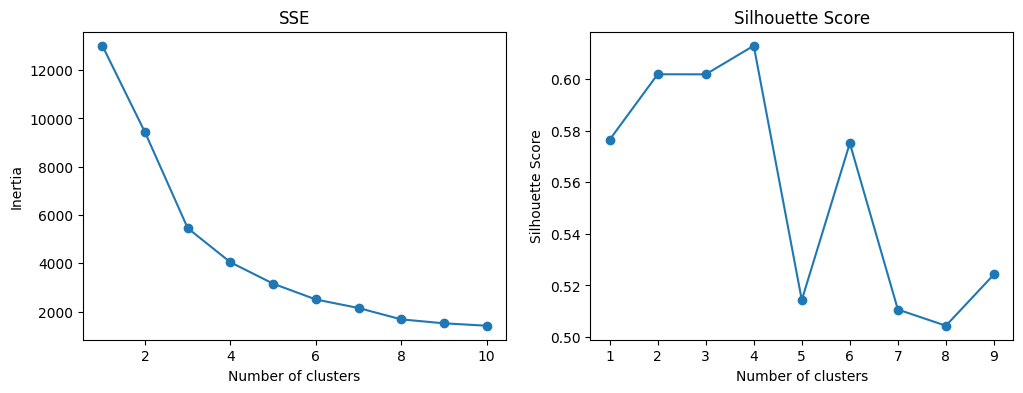

In [6]:
SSE = []
ss = []

for cluster in range(1, 11):
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(rfm_scaled)
    SSE.append(kmeans.inertia_)
    labels = kmeans.predict(rfm_scaled)
    if cluster > 1:
        ss.append(silhouette_score(rfm_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,11), SSE, marker='o')
plt.title('SSE')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(range(1,10), ss, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

Dentro del gráfico de evaluación por codo, se puede observar como la inercia comienza a disminuir conforme el número de clústeres aumenta, esto debido a que cada punto tiende a estar cerca de su centroide dentro de clústeres más pequeños. A medida que la disminución de la inercia avanza, alcanza un punto donde la disminución es significativa, es en este punto donde se forma un "codo" dentro del gráfico. Este punto (Número de clústeres), se considera como el punto óptimo en términos de equilibrio entre compacidad de los clústeres y número de clústeres.

- <b>Este análisis corresponde al gráfico de codos que se puede apreciar en el panel izquierdo</b>

Por otro lado, en el análisis de silueta se busca maximizar el valor de la medida de la silueta para decidir el número óptimo de clústeres en un análisis de clustering. Cuando el valor de esta silueta es cercano a 1 indica que los clústeres se encuentran bien definidos y que los puntos están bien separados de otros clústeres, lo que sugiere una estructura apropiada de clustering.

- <b>En el análisis de silueta el máximo se lo representará con el valor <i>k</i> que será diferente dentro de cada ejecución</b>

In [7]:
k = ss.index(max(ss)) + 1

kmeans = KMeans(n_clusters=k)
rfm_cl = rfm.copy()
rfm_cl['Cluster'] = kmeans.fit_predict(rfm_scaled)

display(rfm_cl)

silhouette_avg = silhouette_score(rfm_scaled, rfm_cl['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,2
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,310,17,334.40,2
...,...,...,...,...
18280.0,277,10,180.60,2
18281.0,180,7,80.82,2
18282.0,7,12,178.05,0


Silhouette Score: 0.5999220684921328


#### Visualización de Clústeres

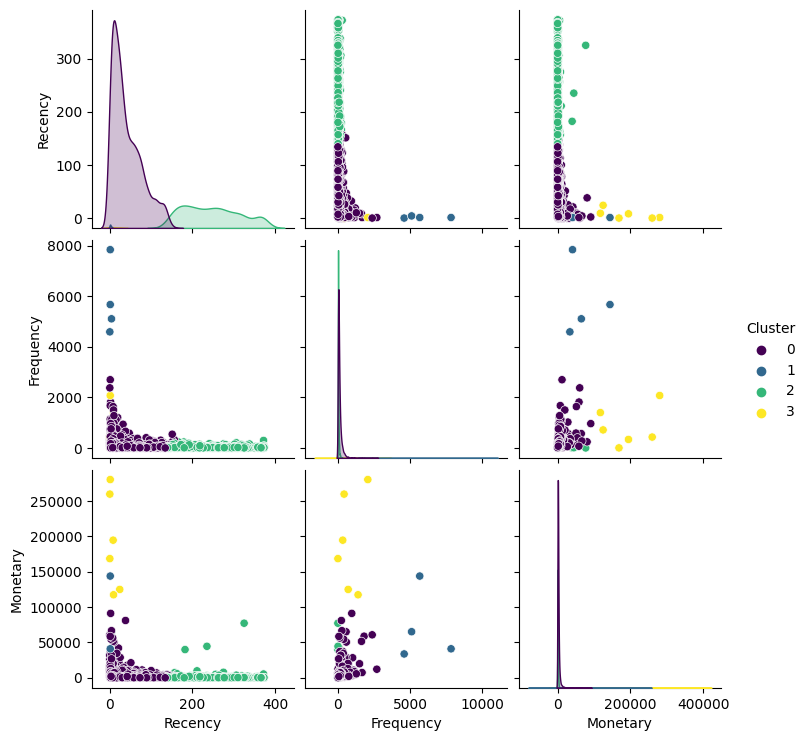

In [8]:
sns.pairplot(rfm_cl, hue='Cluster', palette='viridis')
plt.show()

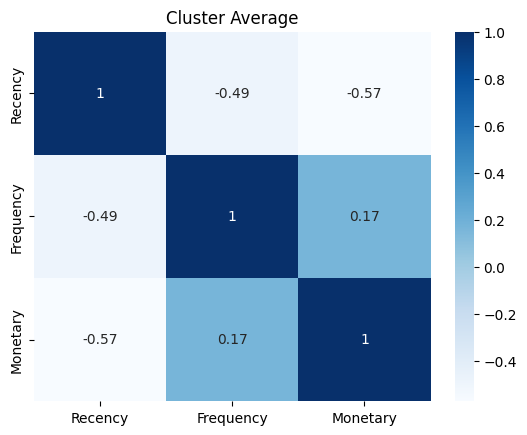

In [9]:
cluster_avg = rfm_cl.groupby('Cluster').mean()
sns.heatmap(cluster_avg.corr(), annot=True, cmap='Blues')
plt.title('Cluster Average')
plt.show()

In [10]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(rfm_scaled)

pc_transformation = pd.DataFrame(data=principal_components,
                                 columns=['PC1','PC2'])

kmeans = KMeans(n_clusters=k, n_init='auto').fit(rfm_scaled)

data_cl = rfm.copy()
data_cl['Cluster'] = kmeans.labels_.astype('str')
data_cl.head()

pc_transformation['Cluster'] = kmeans.labels_.astype('str')

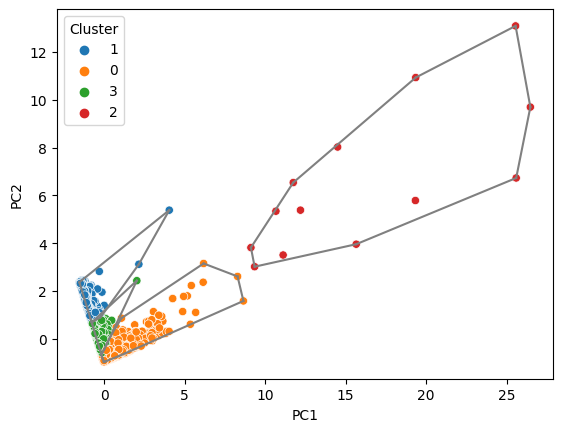

In [ ]:
def plot_convex_hull(data_hull, cl_col, colx = "PC1", coly = "PC2"):
    sns.scatterplot(x=data_hull[colx], y=data_hull[coly], hue=data_hull[cl_col])

    for ci in np.unique(data_hull[cl_col]):
        points = np.array(data_hull[[colx, coly]])
        points = points[np.where(data_hull[cl_col] == ci)[0]]
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex,1], 'grey')

plot_convex_hull(pc_transformation, 'Cluster')
plt.show()

Se construyó un gráfico de dispersión utilizando las dos primeras componentes y los colores como indicadores de cada uno de los clústeres, en este gráfico se pudo observar de mejor manera la separación entre los <i>k</i> clústeres identificados por el algoritmo K-means. Esta separabilidad sugiere que el número de clústeres es adecuado para el estudio de segmentación de clientes, ya que cada grupo mantiene características distintivas entre sí. Por esto, a continuación, describiremos cada uno de los clústeres utilizando las variables originales, permitiendo comprender mejor las características de cada segmento identificado.

In [12]:
pd.DataFrame(pca.components_.T , columns=["PC1","PC2"], index=rfm.columns)

,PC1,PC2
Recency,-0.406489,0.899738
Frequency,0.663804,0.171357
Monetary,0.627798,0.401382


Con los datos presentados, se puede observar que la componente 1 (PC1) está relacionada principalmente con las variables Frequency y Monetary Value, debido a que mantienen valores absolutos altos de carga (loading). Por otro lado, la componente 2 (PC2) está relacionada con la variable Recency.

- La relación entre Frequency y Monetary es bastante cercana debido a que la diferencia entre sus valores es 0.04 unidades, lo que nos puede dar a entender que si una de ellas incrementa la otra variable también tendrá un crecimiento similar.

- Recency tiene baja correlación con ambas variables, es totalmente ortogonal a una de ellas y parcialmente con la otra, como se observa en el gráfico biplot de la parte inferior.

[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


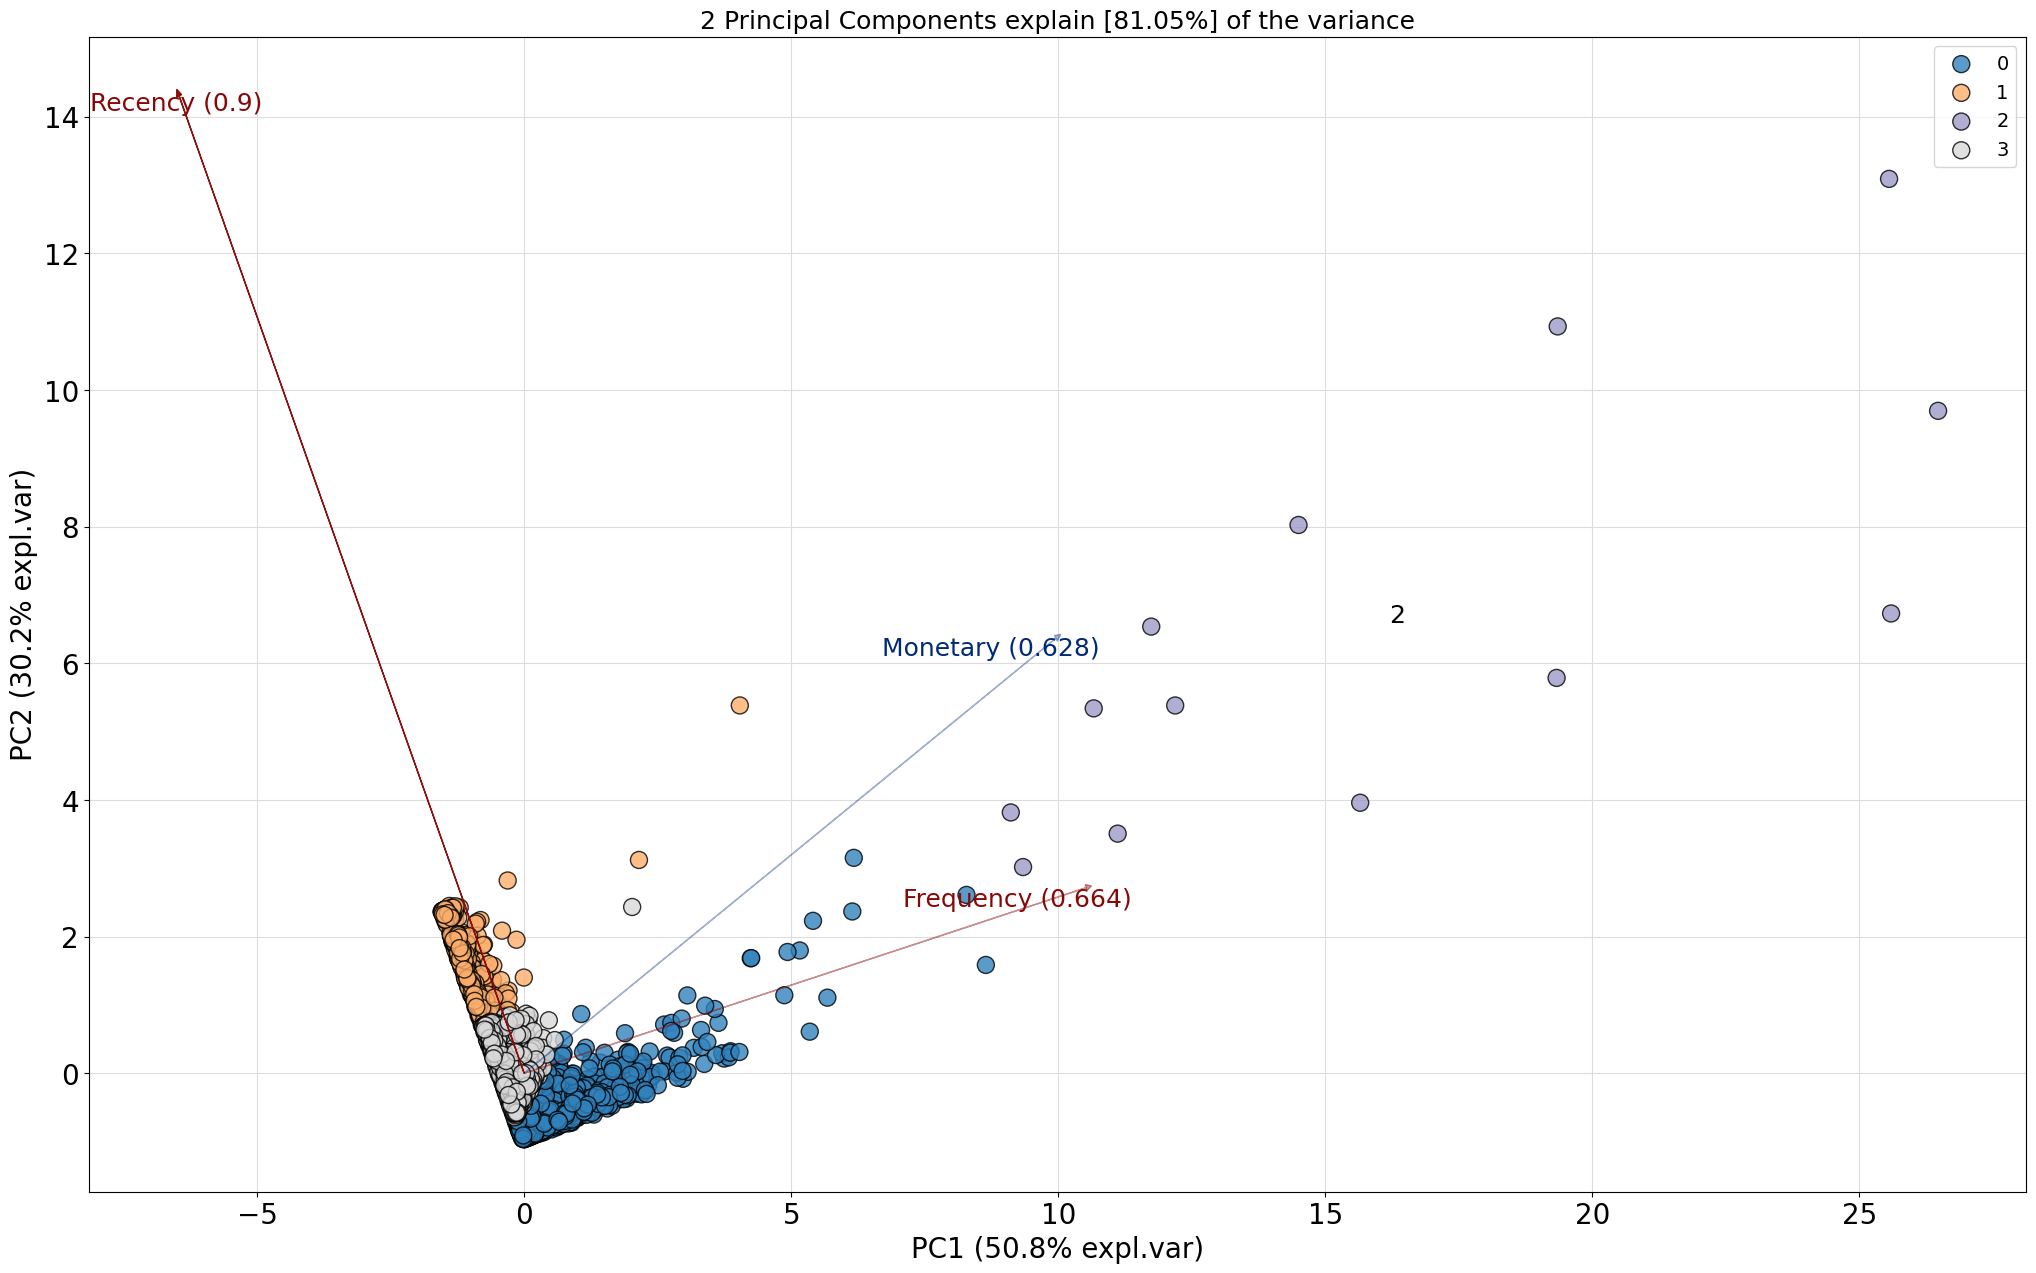

In [ ]:
model = pca(n_components=2)

results = model.fit_transform(X=pd.DataFrame(rfm_scaled, columns=rfm.columns), row_labels=kmeans.labels_.astype('str'))

fig, ax = model.biplot(n_feat=k)
plt.show()

#### DBSCAN

Es un método de aprendizaje no supervisado que divide los puntos de datos en un número específico de grupos, de tal manera que los puntos de datos en los mismos grupos tienen propiedades similares y que aquellos que se encuentran en grupos diferentes tengan diferentes propiedades en algún sentido.

Para la evaluación de este método se utiliza <b>Silhouette's Score</b> esta métrica se encuentra dentro del rango de -1 a 1. Un valor cercano a 1 demuestra que un punto de datos es compacto con el clúster al que pertenece, y se encuentra alejado de otros clústeres. El peor valor para esta métrica es -1 y un valor cercano a 0 puede demostrar clústeres superpuestos.

<i>Fuente: [Geeks for Geeks - DBSCAN Clustering in ML | Density based clustering](https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/)</i>

- Se realizará una comparación entre los resultados obtenidos mediante el algoritmo KMeans con los resultados de DBSCAN, con el fin de determinar cuál de los dos métodos es el más apropiado para abordar el estudio en específico.
- Para esto se analizarán diversos aspectos, como la cohesión de los clústeres, la separación entre estos y la consistencia de los resultados, con la finalidad de tomar una decisión informada sobre el método a utilizar en el análisis de los datos.

In [15]:
X = rfm.iloc[:, 1:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

rfm_db = rfm.copy()
rfm_db['DBSCAN_Cluster'] = dbscan_labels
data_cl['DBSCAN_Cluster'] = dbscan_labels.astype('str')

pc_transformation['DBSCAN_Cluster'] = dbscan_labels.astype('str')

display(data_cl)

,Recency,Frequency,Monetary,Cluster,DBSCAN_Cluster
CustomerID,,,,,
12346.0,325,1,77183.60,1,-1
12347.0,2,182,4310.00,0,0
12348.0,75,31,1797.24,3,0
12349.0,18,73,1757.55,0,0
12350.0,310,17,334.40,1,0
...,...,...,...,...,...
18280.0,277,10,180.60,1,0
18281.0,180,7,80.82,3,0
18282.0,7,12,178.05,0,0


In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

rfm_db['PCA1'] = X_pca[:,0]
rfm_db['PCA2'] = X_pca[:,1]

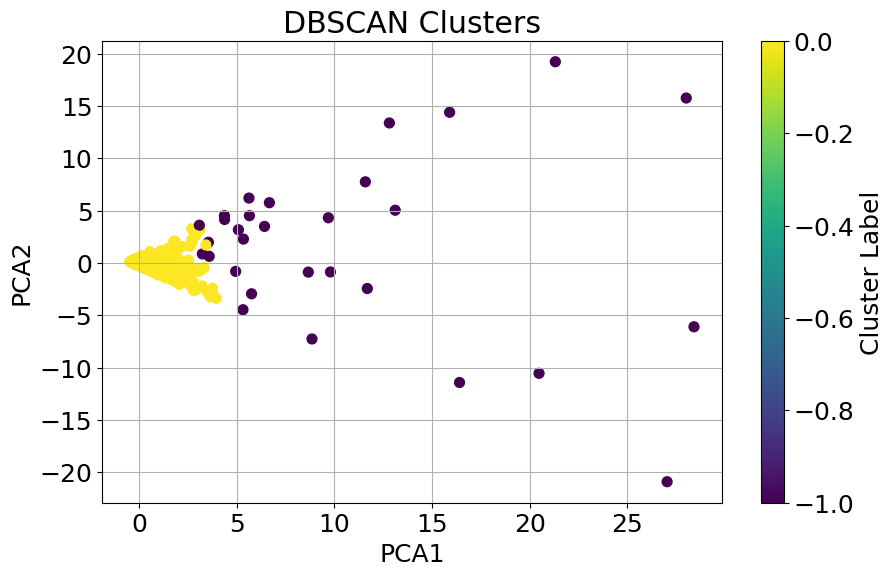

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(rfm_db['PCA1'], rfm_db['PCA2'], c=rfm_db['DBSCAN_Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

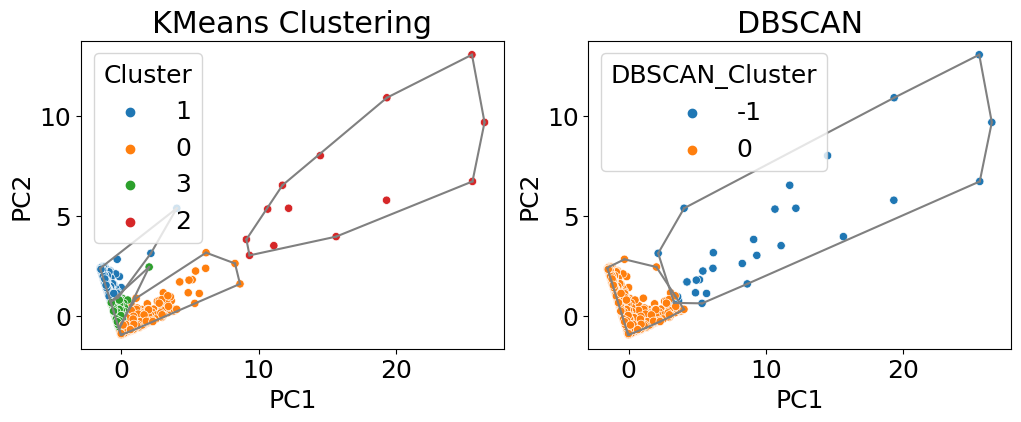

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_convex_hull(pc_transformation, 'Cluster')
plt.title('KMeans Clustering')
plt.subplot(1,2,2)
plot_convex_hull(pc_transformation, 'DBSCAN_Cluster')
plt.title('DBSCAN')
plt.show()

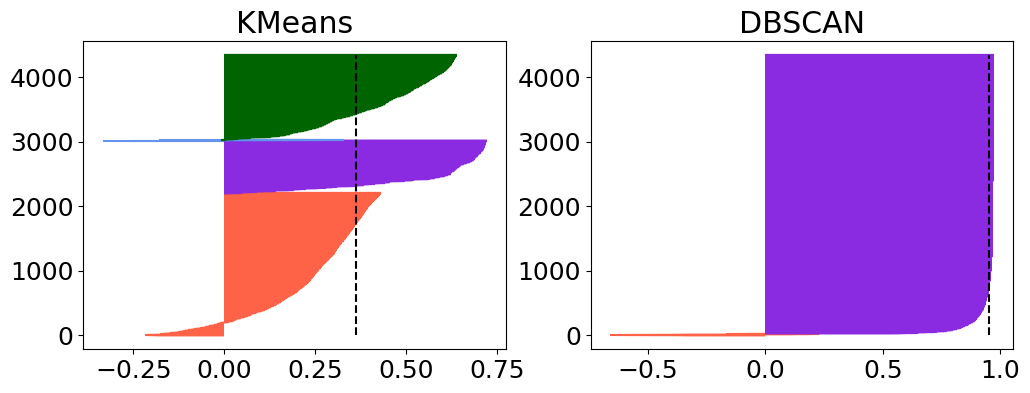

In [21]:
def plot_silhouette_scores(data_scaled, labels):
    samples_silhouette_score = silhouette_samples(data_scaled, labels, metric='euclidean')

    silhouette_avg = silhouette_score(data_scaled, labels)

    data_ss = pd.DataFrame({'silhouette_score': samples_silhouette_score,
                            'labels': labels})
    
    cl, obs_cl = np.unique(data_ss.labels, return_counts=True)

    colorlist =["tomato","blueviolet","cornflowerblue","darkgreen","skyblue","mediumseagreen"]

    for i, cli in enumerate(cl):
        data_ssc = data_ss.query("labels == '"+cli+"'").sort_values(by="silhouette_score")
        for oi, ssi in enumerate(data_ssc.silhouette_score):
            if i > 0:
                oi += obs_cl[:i].cumsum()[-1]
            plt.hlines(oi, 0, ssi, colors=colorlist[i])
    plt.vlines(silhouette_avg, 0, len(labels), linestyle="dashed", colors='k')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_silhouette_scores(rfm_scaled, data_cl.Cluster)
plt.title('KMeans')
plt.subplot(1,2,2)
plt.title('DBSCAN')
plot_silhouette_scores(X_scaled, data_cl.DBSCAN_Cluster)
plt.show()

In [22]:
silhouette_score(rfm_scaled, data_cl.Cluster), silhouette_score(X_scaled, data_cl.DBSCAN_Cluster)

(0.3621833642388422, 0.9511217706065348)

#### Comparación de modelos

Al comparar los resultados de ambos métodos de clustering, KMeans y DBSCAN, se encontró que ambos métodos generan clústeres bien definidos, lo que sugiere una buena calidad del clustering en ambos casos. Sin embargo, al analizar detalladamente, se observa que la silueta promedio para DBSCAN, con un valor de 0.95, es mucho mayor que la silueta obtenida por KMeans que es de 0.36.

Además, se pudo notar que el método DBSCAN asignó un valor de -1 para ciertos puntos, este valor dentro de este método de clustering solo es asignado a aquellos puntos considerados 'ruidosos' es decir entre los grupos generados uno de ellos es de puntos que el método los tomó como ruidosos.

#### Resultados KMeans

- Para finalizar este análsis se realizará un resumen de los resultados obtenidos implementando KMeans.

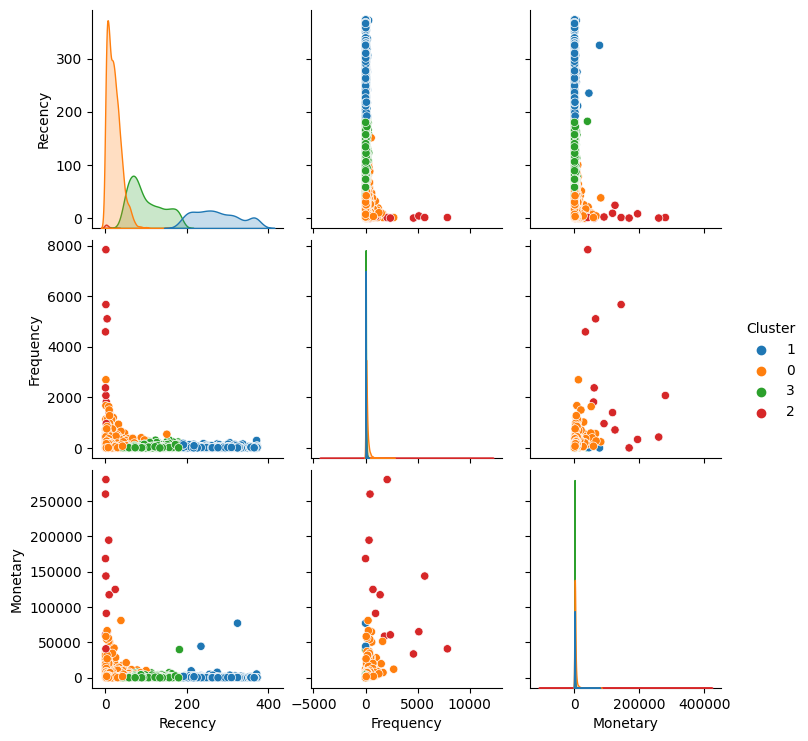

In [23]:
sns.reset_defaults()
sns.pairplot(data_cl, hue='Cluster')
plt.show()

In [24]:
data_cl.groupby('Cluster').describe().T

Cluster                     0             1              2             3
Recency   count   2200.000000    816.000000      13.000000   1309.000000
          mean      20.843182    273.185049       4.000000     99.715814
          std       16.568280     54.827281       6.708204     41.207355
          min        0.000000    187.000000       0.000000     38.000000
          25%        8.000000    226.750000       0.000000     65.000000
          50%       18.000000    266.000000       1.000000     88.000000
          75%       30.000000    313.000000       4.000000    131.000000
          max      151.000000    373.000000      24.000000    187.000000
Frequency count   2200.000000    816.000000      13.000000   1309.000000
          mean     133.983182     25.178922    2565.307692     37.605806
          std      166.739013     28.849129    2456.928617     37.498283
          min        1.000000      1.000000       3.000000      1.000000
          25%       38.000000      8.000000     714.000000     13.000000
          50%       86.000000     17.000000    1818.000000     27.000000
          75%      166.000000     30.000000    4595.000000     49.000000
          max     2700.000000    297.000000    7847.000000    327.000000
Monetary  count   2200.000000    816.000000      13.000000   1309.000000
          mean    2620.405864    609.970344  126118.310000    771.001659
          std     5101.372748   3168.020400   80607.677360   1360.690297
          min       20.800000      3.750000   33719.730000      6.200000
          25%      581.310000    162.925000   60767.900000    256.380000
          50%     1314.745000    304.250000  117379.630000    487.990000
          75%     2773.030000    493.147500  168472.500000    913.680000
          max    81024.840000  77183.600000  280206.020000  39916.500000

#### Entendiendo los Grupos

##### Consumo alto y frecuente

<b>Cluster 0:</b>

- Frecuencia de consumo: Valor medio de 133 facturas.
- Valor monetario de consumo: Consumo promedio de $2620
- Recencia de consumo: El último consumo fue en un promedio de 20 días.

Tipos de clientes en cluster 0:

1. Pequeños Comerciantes: Personas que realizan compras en grandes cantidades y con una alta frecuencia para abastecerse de productos para la venta de derivados, procesados o retail de estos productos.

<b>Cluster 2:</b>

- Frecuencia de consumo: Valor medio de 2565 facturas.
- Valor monetario de consumo: Consumo promedio de $126118
- Recencia de consumo: El último consumo fue en un promedio de 4 días.

Tipos de clientes en cluster 2:

1. Grandes Empresas: Empresas que se abastecen de productos que sirven como materia prima para la elaboración masiva de nuevos productos, esto se correspondería con el alto valor monetario con alta frecuencia de compra.

##### Consumo bajo y no frecuente

<b>Cluster 1:</b>

- Frecuencia de consumo: Valor medio de 25 facturas.
- Valor monetario de consumo: Consumo promedio de $609
- Recencia de consumo: El último consumo fue en un promedio de 273 días.

Tipos de clientes en cluster 1:

1. Emprendedores: Personas que realizan compras de forma periódica con una baja frecuencia para abastecerse de productos que son usados dentro de cada uno de sus emprendimientos, al no estar marcada su línea de negocio, constantemente experimentan con nuevas ideas.

<b>Cluster 3:</b>

- Frecuencia de consumo: Valor medio de 37 facturas.
- Valor monetario de consumo: Consumo promedio de $771
- Recencia de consumo: El último consumo fue en un promedio de 99 días.

Tipos de clientes en cluster 3:

1. Familias: Grupos familiares que realizan la comprta de productos que son necesarios para satisfacer las necesidades básicas del hogar por esta razón buscan abastecerse para una gran cantidad de tiempo y por un bajo costo.

<div class="alert alert-block alert-danger">El análisis realizado se lo llevó a cabo con la ejecución donde el algoritmo de KMeans generó 4 clústeres para la segmentación</div>

In [ ]:
import plotly.express as px

fig = px.scatter_3d(data_cl, x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Cluster')

fig.update_traces(marker_size=4)
fig.show()

#### <b>Conclusiones</b>
El análisis de los datos de consumo permitió identificar dos segmentos de clientes claramente diferenciados según su comportamiento de compra. Cada grupo refleja patrones únicos de frecuencia, valor monetario y recencia, los cuales están asociados a perfiles específicos de consumidores:

- Cluster 0 - Pequeños Comerciantes: Clientes con consumo alto y frecuente que compran grandes volúmenes para la reventa o uso en pequeños negocios.
- Cluster 2 - Grandes Empresas: Empresas con consumo muy alto y altamente frecuente, caracterizadas por grandes transacciones económicas y constante abastecimiento para la producción masiva.
- Cluster 1 - Emprendedores: Clientes con bajo consumo y poca frecuencia de compra, enfocados en emprendimientos pequeños y experimentales.
- Cluster 3 - Familias: Consumidores con necesidades domésticas que buscan satisfacer las demandas del hogar mediante compras moderadamente frecuentes y de bajo costo.

Este estudio destaca cómo los diferentes perfiles requieren estrategias personalizadas para optimizar la relación con el cliente, incrementar la fidelidad y mejorar la eficiencia de las operaciones de marketing y ventas.

#### <b>Recomendaciones</b>
A continuación, se presentan recomendaciones estratégicas para cada segmento identificado:

##### Consumo alto y frecuente

##### <i>Cluster 0:</i>
- Descuentos por volumen: Incentivar compras más grandes mediante precios preferenciales para volúmenes altos.
- Programas de fidelidad: Diseñar sistemas de recompensas para clientes frecuentes, asegurando su fidelización a largo plazo.
- Reabastecimiento automatizado: Proveer opciones de compras recurrentes para garantizar el stock necesario.

##### <i>Cluster 2:</i>
- Contratos personalizados: Establecer acuerdos a largo plazo con descuentos exclusivos para clientes de gran valor.
- Atención personalizada: Asignar un gestor de cuenta dedicado que garantice respuestas rápidas y soluciones a medida.
- Logística preferencial: Mejorar los tiempos de entrega mediante servicios logísticos adaptados a las necesidades empresariales.
- Cross-selling: Ofrecer productos complementarios que optimicen su proceso productivo.

##### Consumo bajo y no frecuente

##### <i>Cluster 1:</i>
- Promociones atractivas: Incentivar compras frecuentes mediante descuentos especiales o paquetes de prueba.
- Marketing digital: Implementar estrategias en redes sociales para captar la atención de este grupo mediante contenido relevante.
- Flexibilidad en pedidos: Ofrecer compras en pequeñas cantidades adaptadas a sus necesidades.

##### <i>Cluster 3:</i>
- Promociones para el hogar: Diseñar ofertas específicas que destaquen el ahorro y la conveniencia en productos básicos.
- Canales de venta alternativos: Potenciar la venta en supermercados y plataformas digitales para facilitar el acceso a los productos.
- Marketing emocional: Diseñar campañas publicitarias que refuercen el valor del ahorro y el cuidado de la familia.